In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# RNN Implementation with Tensorflow

Read the article [A Critical Review of Recurrent Neural Networks for Sequence Learning](https://arxiv.org/pdf/1506.00019.pdf) and used this [post](https://www.kdnuggets.com/2017/04/build-recurrent-neural-network-tensorflow.html) as reference when writing code.

In [3]:
class RNN(tf.Module):
    
    def __init__(self, state_size, batch_size, **kwargs):
        super().__init__(**kwargs)

        # for calculating the next state
        self.w1 = tf.Variable(np.random.rand(state_size + 1, state_size), dtype=tf.float64)
        self.b1 = tf.Variable(np.random.rand(1), dtype=tf.float64)

        # for calculating output
        self.w2 = tf.Variable(np.random.rand(state_size, 1), dtype=tf.float64)
        self.b2 = tf.Variable(np.random.rand(1), dtype=tf.float64)

        self.states = tf.Variable(np.zeros((batch_size, state_size)), shape=(batch_size, state_size))

    # calculate output from current state
    # calcualte next state from current state + input
    # input shap: [batch_size, 1]
    def __call__(self, x):
        input_state_stacked = tf.concat([x, self.states], axis=1)
        output = tf.matmul(self.states, self.w2) + self.b2
        self.states = tf.tanh(tf.matmul(input_state_stacked, self.w1) + self.b1)
        return tf.sigmoid(output)

    def run_batch(self, batch):
        y_preds = []

        for i in range(batch.shape[1]):
            y_preds.append(self(batch[:, i, None]))

        return tf.concat(y_preds, axis=1)


    def __str__(self):
        return " ".join([str(i) for i in self.state.numpy()])

## Training

I will generate binary sequences and train a model to create an offset output

In [4]:
# x: batch of sequences (batch_size, sequence length)
def train(model, batch, y_actual, learning_rate):
    with tf.GradientTape() as tape:
        
        y_pred = model.run_batch(batch)

        current_loss = tf.reduce_mean(tf.square(y_pred - y_actual))

        d_w1, d_b1, d_w2, d_b2 = tape.gradient(current_loss, [model.w1, model.b1, model.w2, model.b2])

        model.w1.assign_sub(learning_rate * d_w1)
        model.b1.assign_sub(learning_rate * d_b1)
        model.w2.assign_sub(learning_rate * d_w2)
        model.b2.assign_sub(learning_rate * d_b2)

    return current_loss.numpy()

In [5]:
# Define a training loop
def training_loop(model, x, y, epochs, learning_rate, print_every = 1, split=0.2):
    split_index = int(x.shape[0] * split)

    x_train = x[split_index:]
    y_train = y[split_index:]
    x_test  = x[:split_index]
    y_test  = y[:split_index]

    train_losses = []
    test_losses  = []
    for epoch in range(epochs):
        batch_train_losses = []
        batch_test_losses  = []
        for batch in range(x_train.shape[0]):
            # Update the model with the single giant batch
            train_loss = train(model, x_train[batch], y_train[batch], learning_rate)
            batch_train_losses.append(train_loss)

        
        for batch in range(x_test.shape[0]):
            y_pred  = model.run_batch(x_test[batch])
            batch_test_losses.append(np.mean((y_pred - y_test[batch])**2))

        loss_average = lambda l: sum(l)/len(l)
        epoch_train_loss = loss_average(batch_train_losses)
        train_losses.append(epoch_train_loss)
        epoch_test_loss = loss_average(batch_test_losses)
        test_losses.append(epoch_test_loss)

        if epoch%print_every == 0 or epoch == epochs-1:
            print("Epoch %d: train loss=%.5f, test loss=%.5f" % (epoch, epoch_train_loss, epoch_test_loss))

    return train_losses, test_losses

In [19]:
SEQUENCE_LENGHT = 20
BATCH_SIZE = 100
N_BATCHES = 20
N_EPOCH = 150

SHIFT_BY = 3
N_STATES = 3

X = np.random.choice([0,1], (N_BATCHES, BATCH_SIZE, SEQUENCE_LENGHT), p=[0.5,0.5])
X[:, :, -SHIFT_BY:] = 0
X = tf.constant(X, dtype = tf.dtypes.float64)

y = np.roll(X, SHIFT_BY, axis=2)
y[:, :, :SHIFT_BY] = 0
y = tf.constant(y, dtype = tf.dtypes.float64)

rnn = RNN(N_STATES, BATCH_SIZE)

In [20]:
train_errors, test_errors = training_loop(rnn, X, y, N_EPOCH, 0.5, 10)

Epoch 0: train loss=0.31563, test loss=0.24492
Epoch 10: train loss=0.24436, test loss=0.24458
Epoch 20: train loss=0.24467, test loss=0.24486
Epoch 30: train loss=0.15317, test loss=0.14384
Epoch 40: train loss=0.00796, test loss=0.00705
Epoch 50: train loss=0.00248, test loss=0.00238
Epoch 60: train loss=0.00145, test loss=0.00141
Epoch 70: train loss=0.00102, test loss=0.00099
Epoch 80: train loss=0.00078, test loss=0.00077
Epoch 90: train loss=0.00063, test loss=0.00062
Epoch 100: train loss=0.00053, test loss=0.00052
Epoch 110: train loss=0.00046, test loss=0.00045
Epoch 120: train loss=0.00040, test loss=0.00040
Epoch 130: train loss=0.00036, test loss=0.00035
Epoch 140: train loss=0.00032, test loss=0.00032
Epoch 149: train loss=0.00030, test loss=0.00029


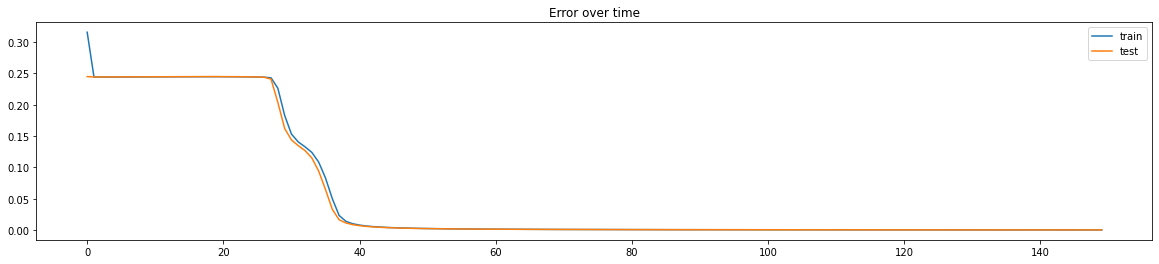

In [24]:
plt.figure(figsize=(20,4))
plt.plot(train_errors, label = 'train')
plt.plot(test_errors, label = 'test')
plt.legend()
plt.title("Error over time")
plt.show()

In [25]:
def plot_data(x, y, batch_index, sequence_index, model = None):
    # plot x to 0.25,
    # plot y to 0.5
    # plot predictions to 1

    plt.plot(x[batch_index, sequence_index, :], label='input')
    plt.plot(y[batch_index, sequence_index, :], label='actual output')

    if model != None:
        preds = []
        states = []
        for index in range(x.shape[2]):
            preds.append(model(x[batch_index, :, index, None])[sequence_index])
            states.append(model.states[sequence_index])
        plt.plot(preds, label='predicted output')
        #plt.plot(states, label='state')

    plt.legend()
    plt.show()

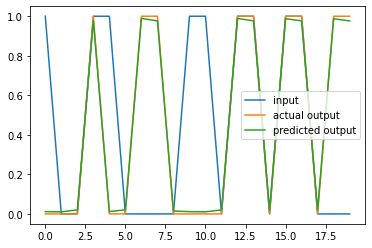

In [26]:
plot_data(X, y, 0, 20, rnn)

## Results

Model was successful at learning to delay an input for a number of timesteps